# Generating trading signals with LightGBM and CatBoost

## Imports & Settings

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd

import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [5]:
sns.set_style('whitegrid')

In [6]:
YEAR = 252
idx = pd.IndexSlice

## Get Data

In [7]:
data = (pd.read_hdf('data.h5', 'model_data')
            .sort_index()
            .loc[idx[:, :'2016'], :])
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1749266 entries, ('A', Timestamp('2010-01-04 00:00:00')) to ('ZION', Timestamp('2016-12-30 00:00:00'))
Data columns (total 33 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol_rank  1749266 non-null  float64
 1   rsi              1735336 non-null  float64
 2   bb_high          1730361 non-null  float64
 3   bb_low           1730359 non-null  float64
 4   NATR             1735336 non-null  float64
 5   ATR              1735336 non-null  float64
 6   PPO              1724391 non-null  float64
 7   MACD             1716431 non-null  float64
 8   sector           1749266 non-null  int64  
 9   r01              1748271 non-null  float64
 10  r05              1744291 non-null  float64
 11  r10              1739316 non-null  float64
 12  r21              1728371 non-null  float64
 13  r42              1707476 non-null  float64
 14  r63              1686581 non-null  float6

In [8]:
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist()

## Model Selection: Lookback, lookahead and roll-forward periods

In [9]:
tickers = data.index.get_level_values('symbol').unique()

In [10]:
lookaheads = [1, 5, 21]

In [11]:
categoricals = ['year', 'month', 'sector', 'weekday']

In [12]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63, 21]

In [13]:
test_params = list(product(lookaheads, train_lengths, test_lengths))

In [14]:
results_path = Path('results', 'us_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Baseline: Linear Regression

In [15]:
lr = LinearRegression()

In [16]:
lr_metrics = []
for lookahead, train_length, test_length in test_params:
    print(lookahead, train_length, test_length)
    label = f'r{lookahead:02}_fwd'
    df = pd.get_dummies(data.loc[:, features + [label]].dropna(), 
                        columns=categoricals, 
                        drop_first=True)
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([
        lookahead, train_length, test_length,
        np.mean(ic),
        spearmanr(preds.y_true, preds.y_pred)[0]
    ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

1 1134 63
1 1134 21
1 252 63
1 252 21
5 1134 63
5 1134 21
5 252 63
5 252 21
21 1134 63
21 1134 21
21 252 63
21 252 21


### Information Coefficient - Distribution by Lookahead

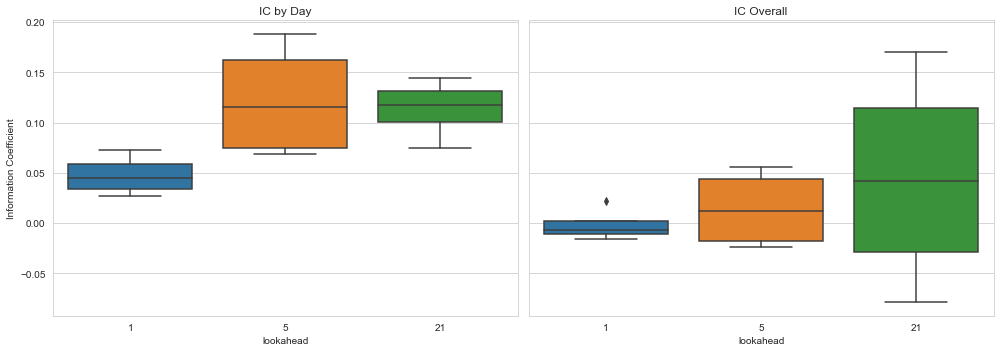

In [17]:
fig, axes =plt.subplots(ncols=2, figsize=(14,5), sharey=True)
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
fig.tight_layout()

### Best Train/Test Period Lengths

In [18]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic_by_day')))

,lookahead,train_length,test_length,ic_by_day,ic
3,1,252,21,0.072497,-0.008860
1,1,1134,21,0.054182,-0.004547
2,1,252,63,0.036205,-0.016078
7,5,252,21,0.188260,-0.023782
5,5,1134,21,0.153993,-0.016251
4,5,1134,63,0.076561,0.055373
9,21,1134,21,0.144771,-0.012503
11,21,252,21,0.126590,-0.078876
8,21,1134,63,0.108476,0.096012


In [19]:
lr_metrics.to_csv(results_path / 'lin_reg_metrics.csv', index=False)

## LightGBM Model Tuning

In [20]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Hyperparameter Options

In [21]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   verbose=-1)

In [22]:
learning_rate_ops = [.01, .1, .3]
max_depths = [2, 3, 5, 7]
num_leaves_opts = [2 ** i for i in max_depths]
feature_fraction_opts = [.3, .6, .95]
min_data_in_leaf_opts = [250, 500, 1000]

In [23]:
param_names = ['learning_rate', 'num_leaves',
               'feature_fraction', 'min_data_in_leaf']

In [24]:
cv_params = list(product(learning_rate_ops,
                         num_leaves_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_params = len(cv_params)
print(f'# Parameters: {n_params}')

# Parameters: 108


### Train/Test Period Lengths

In [25]:
lookaheads = [1, 5, 21]
label_dict = dict(zip(lookaheads, labels))

In [26]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63]

In [27]:
test_params = list(product(lookaheads, train_lengths, test_lengths))
n = len(test_params)
test_param_sample = np.random.choice(list(range(n)), size=int(n), replace=False)
test_params = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params))

Train configs: 6


### Categorical Variables

In [28]:
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Custom Loss Function: Information Coefficient

In [29]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

### Run Cross-Validation

In [30]:
lgb_store = Path(results_path / 'tuning_lgb.h5')

In [31]:
labels = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(labels).tolist()

In [32]:
label_dict = dict(zip(lookaheads, labels))

In [33]:
num_iterations = [10, 25, 50, 75] + list(range(100, 501, 50))
num_boost_round = num_iterations[-1]

In [34]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [35]:
for lookahead, train_length, test_length in test_params:
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 2),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | '
          f'Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | '
          f'Params: {len(cv_params_):3.0f} | '
          f'Train configs: {len(test_params)}')

    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              lookahead=lookahead,
                              test_period_length=test_length,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()
    lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                           label=outcome_data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    T = 0
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    for p, param_vals in enumerate(cv_params_):
        key = f'{lookahead}/{train_length}/{test_length}/' + '/'.join([str(p) for p in param_vals])
        params = dict(zip(param_names, param_vals))
        params.update(base_params)

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            lgb_train = lgb_data.subset(train_idx.tolist()).construct()
            model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round,
                              verbose_eval=False)
            if i == 0:
                fi = get_fi(model).to_frame()
            else:
                fi[i] = get_fi(model)

            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_name()]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()

        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        t = time() - start
        T += t
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n, daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        msg = f'{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["learning_rate"]:5.2f} | '
        msg += f'{params["num_leaves"]:3.0f} | {params["feature_fraction"]:3.0%} | {params["min_data_in_leaf"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)

        metrics.to_hdf(lgb_store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(lgb_store, 'daily_ic/' + key)
        fi.T.describe().T.assign(**params).to_hdf(lgb_store, 'fi/' + key)
        cv_preds.to_hdf(lgb_store, 'predictions/' + key)

Lookahead:  1 | Train: 1134 | Test: 63 | Params:  54 | Train configs: 6
  0 | 00:20:11 (1211) |  0.30 |   4 | 95% | 1000 |   2.20% |  1.80% |  400 |  2.00% |  200
  1 | 00:32:43 (753) |  0.01 |   4 | 60% |  500 |   1.32% |  0.75% |   75 |  1.00% |  100
  2 | 00:45:20 (756) |  0.10 |   4 | 60% |  500 |   2.78% |  1.39% |  500 |  1.40% |  350
  3 | 02:41:26 (6967) |  0.10 | 128 | 95% |  250 |   3.81% |  1.47% |  100 |  1.61% |  350
  4 | 03:00:57 (1170) |  0.01 |   8 | 30% |  500 |   1.29% |  1.25% |  500 |  0.94% |  400
  5 | 03:21:13 (1217) |  0.10 |   8 | 30% |  250 |   2.39% |  1.87% |  500 |  1.54% |  200
  6 | 05:25:10 (7437) |  0.10 | 128 | 95% |  500 |   3.17% |  1.77% |  200 |  1.76% |  300
  7 | 07:04:44 (5974) |  0.10 | 128 | 60% |  250 |   3.13% |  1.60% |  150 |  1.66% |  350
  8 | 07:24:02 (1158) |  0.10 |   8 | 30% | 1000 |   2.43% |  1.83% |  350 |  1.74% |  250
  9 | 07:44:13 (1211) |  0.01 |   8 | 30% | 1000 |   1.79% |  1.28% |  500 |  1.33% |  450


KeyboardInterrupt: 

## CatBoost Model Tuning

### Hyperparameter Options

In [ ]:
param_names = ['max_depth', 'min_child_samples']

max_depth_opts = [3, 5, 7, 9]
min_child_samples_opts = [20, 250, 500]

In [ ]:
cv_params = list(product(max_depth_opts,
                         min_child_samples_opts))
n_params = len(cv_params)

### Train/Test Period Lengths

In [ ]:
lookaheads = [1, 5, 21]
label_dict = dict(zip(lookaheads, labels))

In [ ]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63]

In [ ]:
test_params = list(product(lookaheads,
                           train_lengths,
                           test_lengths))

### Custom Loss Function

In [ ]:
class CatBoostIC(object):
    """Custom IC eval metric for CatBoost"""

    def is_max_optimal(self):
        # Returns whether great values of metric are better
        return True

    def evaluate(self, approxes, target, weight):
        target = np.array(target)
        approxes = np.array(approxes).reshape(-1)
        rho = spearmanr(approxes, target)[0]
        return rho, 1

    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return error

### Run Cross-Validation

In [ ]:
cb_store = Path(results_path / 'tuning_catboost.h5')

In [ ]:
num_iterations = [10, 25, 50, 75] + list(range(100, 1001, 100))
num_boost_round = num_iterations[-1]

In [ ]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [ ]:
for lookahead, train_length, test_length in test_params:
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 1),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f} | Train configs: {len(test_params)}')
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              lookahead=lookahead,
                              test_period_length=test_length,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()
    cat_cols_idx = [outcome_data.columns.get_loc(c) for c in categoricals]
    catboost_data = Pool(label=outcome_data[label],
                         data=outcome_data.drop(label, axis=1),
                         cat_features=cat_cols_idx)
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    key = f'{lookahead}/{train_length}/{test_length}'
    T = 0
    for p, param_vals in enumerate(cv_params_):
        params = dict(zip(param_names, param_vals))
        params['task_type'] = 'GPU'

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            train_set = catboost_data.slice(train_idx.tolist())

            model = CatBoostRegressor(**params)
            model.fit(X=train_set,
                      verbose_eval=False)

            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_names_]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, ntree_end=n) for n in num_iterations}
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()

        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        t = time() - start
        T += t
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n, daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        msg = f'{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["max_depth"]:3.0f} | {params["min_child_samples"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)
        metrics.to_hdf(cb_store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(cb_store, 'daily_ic/' + key)
        cv_preds.to_hdf(cb_store, 'predictions/' + key)

## Generate LightGBM predictions

We'll generate predictions for 2016 using LightGBM; you can do so for CatBoost following the same pattern.

### Model Configuration

In [ ]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   verbose=-1)

categoricals = ['year', 'month', 'sector', 'weekday']

In [ ]:
lookahead = 1

### Get Data

In [ ]:
data = pd.read_hdf('data.h5', 'model_data').sort_index()
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist()
label = f'r{lookahead:02}_fwd'
data = data.loc[idx[:, '2010':], features + [label]].dropna()
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

In [ ]:
lgb_data = lgb.Dataset(data=data[features],
                       label=data[label],
                       categorical_feature=categoricals,
                       free_raw_data=False)

### Generate predictions

In [ ]:
for position in range(10):
    params = get_params(daily_ic_avg,
                    t=lookahead,
                    best=position)
    
    params = params.to_dict()
    
    for p in ['min_data_in_leaf', 'num_leaves']:
        params[p] = int(params[p])
    train_length = int(params.pop('train_length'))
    test_length = int(params.pop('test_length'))
    num_boost_round = int(params.pop('boost_rounds'))
    params.update(base_params)

    print(f'\nPosition: {position:02}')

    n_splits = int(1 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    predictions = []
    start = time()
    for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
        print(i, end=' ', flush=True)
        lgb_train = lgb_data.subset(train_idx.tolist()).construct()

        model = lgb.train(params=params,
                          train_set=lgb_train,
                          num_boost_round=num_boost_round,
                          verbose_eval=False)

        test_set = data.iloc[test_idx, :]
        y_test = test_set.loc[:, label].to_frame('y_test')
        y_pred = model.predict(test_set.loc[:, model.feature_name()])
        predictions.append(y_test.assign(prediction=y_pred))

    if position == 0:
        test_predictions = (pd.concat(predictions)
                            .rename(columns={'prediction': position}))
    else:
        test_predictions[position] = pd.concat(predictions).prediction

by_day = test_predictions.groupby(level='date')
for position in range(10):
    if position == 0:
        ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
    else:
        ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])
print(ic_by_day.describe())
ic_by_day.to_csv(f'ic_by_day_{lookahead:02}.csv')

test_predictions.to_hdf(results_path / 'predictions.h5', f'lgb/test/{lookahead:02}')

### AlphaLens Analysis

#### Prepare Factor Data

In [ ]:
t = 1
idx = pd.IndexSlice
factor = (pd.read_hdf(results_path / 'predictions.h5', f'lgb/test/{t:02}')
          .drop('y_test', axis=1)
          .iloc[:, :5]
          .mean(1)
          .sort_index()
          .dropna()
          .tz_localize('UTC', level='date')
          .swaplevel())

In [ ]:
dates = factor.index.get_level_values('date')
dates.min(), dates.max()

In [ ]:
factor.head()

#### Select next available trade prices

Using next available prices.

In [ ]:
tickers = factor.index.get_level_values('symbol').unique()

In [ ]:
trade_prices = get_trade_prices(tickers)
trade_prices.info()

#### Get AlphaLens Inputs

In [ ]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

#### Summary Tearsheet

In [ ]:
create_summary_tear_sheet(factor_data)

#### Full Tearsheet

In [ ]:
create_full_tear_sheet(factor_data,
                       long_short=True, 
                       group_neutral=False, 
                       by_group=True)